In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import pickle as pkl
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import keras
import neon
import seaborn as sns
import tensorflow as tf

from cs231n.classifiers.neural_net import TwoLayerNet
from cs231n.data_utils import get_CIFAR10_data

# Matplotlib settings
%matplotlib inline
# set default size of plots
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/
# -->     autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

pkgs = [matplotlib, np, keras, neon, sns, tf]
for pkg in pkgs:
    print('{}: {}'.format(pkg.__name__, pkg.__version__))

Using TensorFlow backend.


matplotlib: 2.0.0
numpy: 1.12.0
keras: 1.2.2
neon: 1.5.4
seaborn: 0.7.1
tensorflow: 1.0.0


In [2]:
data = get_CIFAR10_data('../data/cifar10/')

for k, v in data.iteritems():
    print('{}.shape: {}'.format(k, v.shape))

X_val.shape: (1000, 3, 32, 32)
X_train.shape: (49000, 3, 32, 32)
X_test.shape: (1000, 3, 32, 32)
y_val.shape: (1000,)
y_train.shape: (49000,)
y_test.shape: (1000,)


In [3]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

# Constants
num_classes = 10
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

# Flatten images
X_train = X_train.reshape(num_train, -1)
X_val = X_val.reshape(num_val, -1)
X_test = X_test.reshape(num_test, -1)

print('X_train.shape =', X_train.shape)
print('X_val.shape =', X_val.shape)
print('X_test.shape =', X_test.shape)
print('y_train.shape =', y_train.shape)
print('y_val.shape =', y_val.shape)
print('y_test.shape =', y_test.shape)

X_train.shape = (49000, 3072)
X_val.shape = (1000, 3072)
X_test.shape = (1000, 3072)
y_train.shape = (49000,)
y_val.shape = (1000,)
y_test.shape = (1000,)


## My implementation of the model

iteration 0/1000: loss 5.529093
iteration 100/1000: loss 3.990475
iteration 200/1000: loss 3.653593
iteration 300/1000: loss 3.386045
iteration 400/1000: loss 3.204783
iteration 500/1000: loss 3.007843
iteration 600/1000: loss 2.800341
iteration 700/1000: loss 2.515164
iteration 800/1000: loss 2.565128
iteration 900/1000: loss 2.327711
train_acc = 0.52, val_acc = 0.43


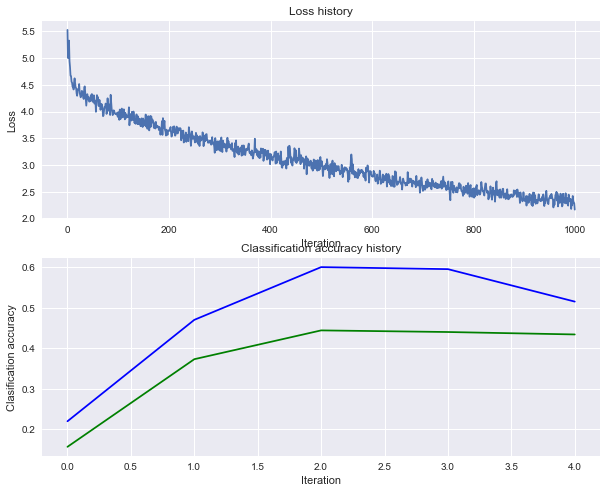

In [28]:
input_dim = 3 * 32 * 32
hidden_dim = 50
#std = np.sqrt(2.0 / num_train)
#std = np.sqrt(2.0 / input_dim)
std = 0.01
num_iters = 1000
batch_size = 200

lr = 0.00179573608347
#decay = 0.960001695353
decay = 1
reg = 0.316227766017

net = TwoLayerNet(input_dim, hidden_dim, num_classes, std)
stats = net.train(X_train, y_train, X_val, y_val,
                  num_iters=num_iters,
                  batch_size=batch_size,
                  learning_rate=lr,
                  learning_rate_decay=decay,
                  reg=reg,
                  verbose=True)

print('train_acc = {:.2f}, val_acc = {:.2f}'.format(
    stats['train_acc_history'][-1], stats['val_acc_history'][-1]))

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train', color='blue')
plt.plot(stats['val_acc_history'], label='val', color='green')
plt.title('Classification accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Clasification accuracy')
plt.show()

## Keras implementation of the model

Train on 49000 samples, validate on 1000 samples
Epoch 1/10
49000/49000 [==============================] - 2s - loss: 6.9998 - acc: 0.2383 - val_loss: 6.9205 - val_acc: 0.2610

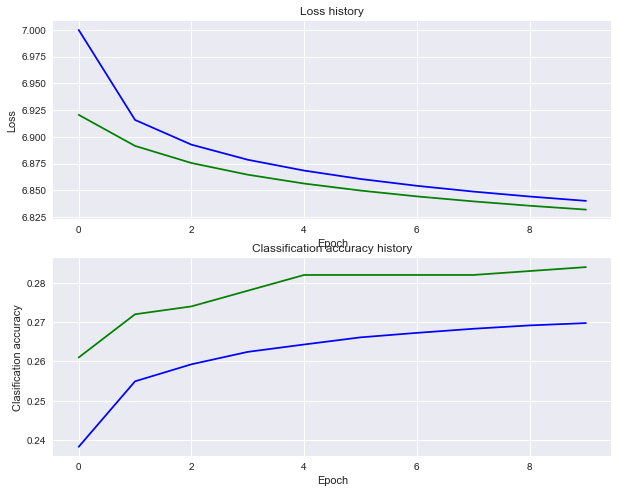

In [68]:
from keras.models import Sequential
from keras.initializations import normal
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

# For tensorflow > 0.9.0 see the issue
# https://github.com/fchollet/keras/issues/3857
# Work around suggested by:
# (al626 commented on 4 Oct 2016)
import tensorflow as tf
tf.python.control_flow_ops = tf

y_dummy_train = to_categorical(y_train)
y_dummy_test = to_categorical(y_test)
y_dummy_val = to_categorical(y_val)

## A fully connected two-layer neural net

input_dim = 3 * 32 * 32
hidden_dim = 50
num_classes = 10
num_epochs = 10
batch_size = 200
std = 1e-2

def my_init(shape, name='djn'):
    return normal(shape, scale=std, name=name)

init = my_init
#init = 'lecun_uniform'

# Found these parameters from cs231n 2-layer model:
reg = 0.316227766017
lr = 0.00179573608347
#decay = 0.960001695353
decay = 1

optimizer = SGD(lr=lr, decay=decay)

model = Sequential()
model.add(Dense(hidden_dim,
                input_dim=input_dim,
                init=init,
                W_regularizer=l2(reg),
                activation='relu'))
model.add(Dense(num_classes,
                init=init,
                W_regularizer=l2(reg),
                activation='softmax'))
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              #loss='categorical_crossentropy',
              metrics=['accuracy'])
res = model.fit(X_train,
                y_train,
                #y_dummy_train,
                validation_data=(X_val, y_val),
                #validation_data=(X_val, y_dummy_val),
                nb_epoch=num_epochs,
                batch_size=batch_size)

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(res.history['loss'], label='train', color='blue')
plt.plot(res.history['val_loss'], label='val', color='green')
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(res.history['acc'], label='train', color='blue')
plt.plot(res.history['val_acc'], label='val', color='green')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()


### Question??!

I don't understand what is the difference between my implementation for the cs231n assignments, and the keras implementation. I am using the same architecture, hyperparameters and data! A small difference is understandable. But here, the validation accuracy numbers are widely different (mine ~46% to keras ~18%). Mine is faster too compared to the keras implementation.

Any idea?!

The loss function outputs seem completely unrealistic.

## Neon implementation of the model

In [59]:
from neon.backends import gen_backend
from neon.callbacks import Callbacks
from neon.data import ArrayIterator
from neon.initializers import Constant, Gaussian
from neon.layers import Affine, GeneralizedCost
from neon.models import Model
from neon.optimizers import GradientDescentMomentum
from neon.transforms import Rectlin, Softmax
from neon.transforms import CrossEntropyMulti
from neon.transforms import Accuracy

input_dim = 3 * 32 * 32
hidden_dim = 50
num_classes = 10
num_epochs = 10
batch_size = 200
std = 1e-2

# Found these parameters from cs231n 2-layer model:
reg = 0.316227766017
lr = 0.00179573608347
#decay = 0.960001695353
decay = 1

gen_backend(backend='cpu', batch_size=batch_size)

train = ArrayIterator(X=X_train, y=y_train, nclass=10)
val = ArrayIterator(X=X_val, y=y_val, nclass=10)

w_init = Gaussian(scale=std)
b_init = Constant(val=0.0)

mlp = Model([
    Affine(hidden_dim, w_init, bias=b_init, activation=Rectlin()),
    Affine(num_classes, w_init, bias=b_init, activation=Softmax())
])

cost = GeneralizedCost(costfunc=CrossEntropyMulti())
optim = GradientDescentMomentum(lr, 0)
metric = Accuracy()
callbacks = Callbacks(mlp, train_set=train, eval_set=val, eval_freq=1, metric=metric)

mlp.fit(train, optimizer=optim, num_epochs=10, cost=cost, callbacks=callbacks)

Epoch 0   [Train |████████████████████|  245/245  batches, 1.76 cost, 1.53s] [CrossEntropyMulti Loss 1.74, 0.02s]
Epoch 1   [Train |████████████████████|  245/245  batches, 1.66 cost, 1.57s] [CrossEntropyMulti Loss 1.65, 0.02s]
Epoch 2   [Train |████████████████████|  245/245  batches, 1.60 cost, 1.58s] [CrossEntropyMulti Loss 1.61, 0.02s]
Epoch 3   [Train |████████████████████|  245/245  batches, 1.56 cost, 1.58s] [CrossEntropyMulti Loss 1.60, 0.02s]
Epoch 4   [Train |████████████████████|  245/245  batches, 1.53 cost, 1.56s] [CrossEntropyMulti Loss 1.60, 0.02s]
Epoch 5   [Train |████████████████████|  245/245  batches, 1.50 cost, 1.57s] [CrossEntropyMulti Loss 1.59, 0.02s]
Epoch 6   [Train |████████████████████|  245/245  batches, 1.48 cost, 1.58s] [CrossEntropyMulti Loss 1.58, 0.02s]
Epoch 7   [Train |████████████████████|  245/245  batches, 1.46 cost, 1.57s] [CrossEntropyMulti Loss 1.60, 0.02s]
Epoch 8   [Train |████████████████████|  245/245  batches, 1.43 cost, 1.66s] [CrossEntro

In [57]:
acc = mlp.eval(val, metric=Accuracy())*100
print('Accuracy: {}'.format(acc))

Accuracy: [ 46.29999924]


### Comments

Even with neon validation accuracy is ~46% (comparable to mine).

Pros for neon:
* Fast (keras was slowest, this is fastest).

Cons for neon:
* Couldn't find how to do L2 regularization for the weights.
* Couldn't figure out how to capture the training history, and validation accuracy history at each epoch (or iteration) to draw the graphs.